# Pricing Problem

### Background

I am a data scientist at a software company that has implemented a price optimization test. My job is to determine whether or not the test was successful. 

### Major Findings

1) There is a small (14%) increase in the revenue per visitor with the new price of \$59, but was not significant at p <0.05. 

2) The conversion rate was very low in both groups and only 1.83% overall.

3) The majority of purchases were from home addresses using mobile OS or Windows who found their way to the website directly or via ads.

4) Power analysis using the old price as a control specified a minimum of 8632 visitors per group for a significance level of p < 0.01, so the test could have stopped after day 6.  

### Recommended actions

1) Leave the price at \$39 and focus on increasing conversion rate.

2) Invest in search engine optimization to boost traffic to the site. 

3) Once the search engine optimization becomes effective, reduce spending on ads to increase your revenue per visitor.

4) Look further into the device types since MacOS users are less likely to visit the page. If it is a UI/UX issue, have the web design team improve it as cross-platform. If the software the company is selling is not MacOS compatible, this is an untapped market for future releases.

5) Most visitors to the website were from residential buildings, leaving businesses and government as untapped markets. If the software is relevant to business and government, future promotions, bulk discounts, and other marketing strategies should include these to increase revenue.

--------

## Implementation Notes
#### Time-consuming tasks were saved to file to be retrieved as needed in the actual analysis
- Many of these blocks only need to be run once and the output saved to be reloaded later
- These are indicated with empty brackets beside the blocks.
- For example: 
    - The code to extract geocode data and merge it with the test data took 15 hours for the full dataset
    - The code to identify orphan IDs took 1 hour
    - The code to identify inactive users took nearly 2 hours

**Requirements** 

- User segmentation

- Insights about the segments behaving "differently"

- Any other insights

**Parameters**

- Null hypothesis: The price increase does not increase revenue

- Test hypothesis: The price increase does increase revenue

#### Population demographics

- 66% are not naive to new price (biased) 
- 33% are naive to new price
- These were adjusted slightly after cleaning the data and eliminating inconsistent price and test labels
- There are 275,616 unique user_ids, but only 996 unique latitude/longitude coordinates._
    - This could mean multiple users from the same location or users from one location are using different accounts.
- There are 41184 users in the test data without demographics in the user table.
    - Assuming these are visitors who either do not have an account or did not log into their account when they visited

#### Time Series

- Times are all local time
- To do any comparisons, they will have to be converted to UTC

**Specific Questions to Answer**
- Should we sell at 39  or 59?
- What are your main findings looking at the data?
- After how many days you would have stopped the test?

## Dependencies, Defaults, and Definitions

In [244]:
import pandas as pd
import datetime as dt
from tzwhere import tzwhere as tz
import pytz
from timezonefinder import TimezoneFinder
from geopy.geocoders import Nominatim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom as binom
from IPython.display import HTML
import os
import glob
import seaborn as sns
import geopandas as gpd

## Data Quality check

**Import user table**

In [121]:
df_user = pd.read_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/user_table.csv', dtype = 'unicode')
display(HTML("<hr><font size = 3>User table shape: " + str(df_user.shape)))
display(HTML('<font size = 3>User table columns : '))
display(HTML('<hr>'))
df_user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


#### Visualize user locations

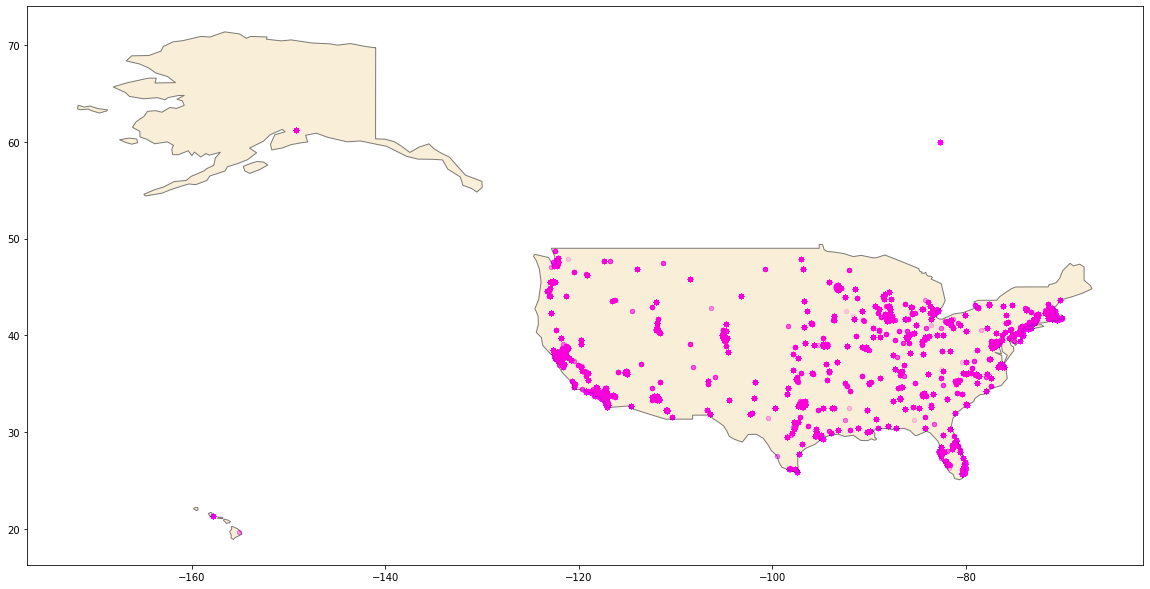

In [346]:
def plot_map(df):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    tmp = df[df.long.astype(float) < 0]
    gdf = gpd.GeoDataFrame(
        tmp, geometry=gpd.points_from_xy(tmp.long, tmp.lat))
    ax = world[world.name == 'United States of America'].plot(
        color='wheat', edgecolor='black', figsize = (20,20),alpha = 0.5)
    gdf.plot(ax=ax, marker = 'o', markersize = 20, color = 'magenta', alpha = 0.025)

plot_map(df_user)

#### Import test data table

In [ ]:
df_test = pd.read_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/test_results.csv', dtype = 'unicode')
df_test = df_test.drop_duplicates()
df_test.user_id = [str(c).replace('.0','') for c in df_test.user_id.values]
display(HTML("Test results shape: " + str(df_test.shape)))
display(HTML('User test columns : ')) 
df_test.head()

#### Check for mismatched price and test variables
- 0 = \$39
- 1 = \$59

In [81]:
mislabeled_0 = df_test[(df_test.test == '0') & (df_test.price == '59')]
mislabeled_1 = df_test[(df_test.test == '1') & (df_test.price == '39')]
display(HTML("<hr><h3><font color = 'blue'>Problem: Mislabeled Price and Test in some rows</h3>"))
display(HTML("<font size = 3><font color = 'blue'>Mislabeled tests ($59 labeled as 0 in test): " + str(mislabeled_0.shape[0])))
display(HTML("<font size = 3><font color = 'blue'>Mislabeled tests ($39 labeled as 1 in test): " + str(mislabeled_1.shape[0])))
display (HTML('<hr>'))

**Check for users with no demographics**

In [ ]:
orphan_ids = [u for u in df_test.user_id.values if u not in df_user.user_id.values]

In [ ]:
df_orphans = df_test.user_id [df_test.user_id.isin(orphan_ids)]
df_orphans.head()
df_orphans.to_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/orphan_ids.csv', index = False)

In [350]:
df_orphans = pd.read_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/orphan_ids.csv', dtype='unicode')
display(HTML("""<hr><h3><font color = 'blue'>Problem: There are """ + str(df_orphans.shape[0]) +  """ users in the test data without 
              demographics in the user table.</h3>"""))
display (HTML('<hr>'))

#### Check for users who have not purchased from the site

In [471]:
inactive = [u for u in df_user.user_id.values if u not in np.unique(df_test.user_id.values)]

In [ ]:
df_inactive = df_user.user_id [df_user.user_id.isin(inactive)]
df_inactive.head()
df_inactive.to_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/inactive_ids.csv', index = False)

In [ ]:
df_inactive = pd.read_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/inactive_ids.csv', dtype='unicode')
display(HTML("""<hr><h3><font color = 'blue'>Problem: There are """ + str(df_inactive.shape[0]) +  """ users in the user 
             whom have not made purchases at either price.</h3>"""))
display (HTML('<hr>'))

**Expand the User Database with Latitude/Longitude Information**

In [ ]:
tzlist = pd.read_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/geonames/allCountries.txt', 
                     delimiter = '\t')
tzlist.columns = ['id', 'city', 'city2', 'state','lat','long', '6','7','8','9','10','11','12','13','14',
                 '15','16','time_zone','date']
tzlist = tzlist[['id','city','state','lat','long','time_zone']]

## Add building name, state, postcode, and time zone
Took more than an hour because of calls to the geocode API. Run once and save the data.

In [ ]:
def get_geodata (df,tzlist):
    """Takes a dataframe with latitude and longitude coordinates
       and adds address type, postcode and state, if applicable, 
       and time zone"""
    
    df2 = pd.DataFrame() # output dataframe
    
    # Requires two reverse geocoders because neither is complete
    # And google lookups aren't free
    locator = Nominatim(user_agent = 'myGeocoder') 
    tf = TimezoneFinder()
    
    # Cycle through the unique lat/long pairs to get location information
    i = 0
    for index, row in df.iterrows():
        #if i % 10 == 0:
        #    print(i, end = ' ')
        print(i, end = ' ')
        new = {'lat': row.lat, 'long': row.long}
        coordinates = str(row['lat']), str(row['long'])
        location = locator.reverse(coordinates)
        tzwhere = tz.tzwhere()
        new['building_type'] = list(location.raw['address'].keys())[0]
        try:
            #new['time_zone'] = tzwhere.tzNameAt(float(row.lat), float(row.long))
            new['time_zone'] = tf.timezone_at(lng=float(row.long), lat=float(row.lat))
        except:
            
            pass
        try:
            new['postcode'] = location.raw['address']['postcode'][:5]
        except:
            pass
        try:
            new['city'] = location.raw['address']['city']
        except:
            pass
        try:
            new['state'] = location.raw['address']['state']
        except:
            pass
        df2 = df2.append(new, ignore_index = True)
        #if i % 10 == 0:
        #    df2.to_csv('data/pricing/full_user_info' + str(i) + '.csv')
        #    df2 = pd.DataFrame()
        #df2.to_csv('data/pricing/full_user_info' + str(i) + '.csv')
        i += 1
    return df2

In [ ]:
timezones = df_user.drop(['user_id','city','country'], axis = 1)
timezones = timezones.drop_duplicates()
timezones = get_geodata(timezones[991:])
timezones.head()

------
### _FINDING: There are 275,616 unique user_ids, but only 996 unique latitude/longitude coordinates._
_This could mean multiple users from the same location or users from one location are using different accounts._

----

**Concatenate the batched time zone files**
- Only need to run once

In [ ]:
def get_timezones(dir_in):
    timezones = pd.DataFrame()
    dir_working = os.getcwd()
    os.chdir (dir_in)
    i = 1
    for f in glob.glob('*{}'.format('csv')):
        #print(i,f)
        timezones = timezones.append(pd.read_csv(f))
    timezones.to_csv(os.path.join('../','timezones.csv'))
    os.chdir(dir_working)
    return timezones

dir_in = os.path.join('/Users/haleyspeed/Docs/insight/data_challenges','data','pricing','tz')    
#timezones = get_timezones(dir_in)
#timezones.head()

**Load in the previously tagged time zones**

In [ ]:
timezones = pd.read_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/timezones.csv')
cols = [c for c in timezones.columns.values if 'unnamed' not in c.lower()]
timezones = timezones[cols]
timezones.head()

**Add timezones to user table and compare city names as an extra validation**

In [ ]:
def expand_users(df_user, timezones):
    """"""
    df = pd.DataFrame()
    i = 0
    for index, row in df_user.iterrows():
        if i % 500 == 0:
            df.to_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/user/full_user_info_' + 
                     str(i) +'.csv', index = False)
            df = pd.DataFrame()
            print(i, end = ' ')
        new = row
        new['time_zone'] = str(timezones[(timezones['lat'] == row.lat) & 
                                     (timezones['long'] == row.long)].time_zone.values).strip("['']")
        new['nearest_city'] = str(timezones[(timezones['lat'] == row.lat) & 
                                     (timezones['long'] == row.long)].city.values).strip("['']")
        new['state'] = str(timezones[(timezones['lat'] == row.lat) & 
                                     (timezones['long'] == row.long)].state.values).strip("['']")
        new['postcode'] = str(timezones[(timezones['lat'] == row.lat) & 
                                     (timezones['long'] == row.long)].postcode.values).strip("['.']")
        new['building_type'] = str(timezones[(timezones['lat'] == row.lat) & 
                                     (timezones['long'] == row.long)].building_type.values).strip("['']")
        df = df.append(new, ignore_index = True)
        i += 1
    df.to_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/user/full_user_info_' + 
                     str(i) +'.csv', index = False)
    return df

#df_user = expand_users(df_user, timezones)

**concatenate the expanded user table**

In [49]:
def concat(dir_in, dir_out):
    dfo = pd.DataFrame()
    dir_working = os.getcwd()
    os.chdir (dir_in)
    i = 1
    for f in glob.glob('*{}'.format('csv')):
        #print(i,f)
        dfo = dfo.append(pd.read_csv(f))
    dfo.to_csv(dir_out, index = False)
    os.chdir(dir_working)
    return dfo

dir_in = os.path.join('/Users/haleyspeed/Docs/insight/data_challenges','data','pricing','user') 
dir_out = os.path.join('../','extended_user_info_raw.csv')
#df_user = concat_users(dir_in, dir_out)
#df_user.head()

In [ ]:
df_user.shape

**Read in the expanded user table**

In [ ]:
df_user = pd.read_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/extended_user_info_raw.csv', 
                      dtype = 'unicode')
df_user.head()

**Get Missing time zone data**

In [ ]:
df_user.city = np.where(df_user.city.isnull(), df_user.nearest_city, df_user.city)
df_missing = df_user[df_user.time_zone.isnull()]
df_missing = get_geodata (df_missing,tzlist)

print(df_missing.shape)
df_missing.head()


**Intermediate save for missing data**

In [ ]:
df_missing.to_csv('missing.csv')

**Checking for duplicates in extended user list**

In [ ]:
df_user = df_user.drop_duplicates()
df_user.shape

**Checking for duplicates in completed user list**
- Appears that filling in missing data reveals duplicate data
- Follow that up to see which user IDs were duplicated and verify

In [ ]:
dfu = df_user.append(df_missing)
dfu = dfu[dfu.time_zone.isnull() == False]
dfu.shape

**Save the expanded user table**

In [ ]:
dfu.to_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/full_user_info2.csv', index = False)
dfu.head()

## Construct joined database

**Read in orphaned dataframe**

In [ ]:
df_orphans = pd.read_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/orphan_ids.csv', 
                       dtype = 'unicode')
df_orphans.shape

**Read in expanded user database**

In [59]:
dfu = pd.read_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/full_user_info2.csv', dtype = 'unicode')
dfu = dfu.drop_duplicates()
drops = [c for c in dfu.columns.values if 'unnamed' in c.lower()]
dfu = dfu.drop(drops, axis = 1)
dfu.postcode = [str(v).replace('.0','') for v in dfu.postcode.values]
dfu.user_id = [str(v).replace('.0','') for v in dfu.user_id.values]
print(dfu.shape)
dfu.head()

(273981, 10)


,building_type,city,country,lat,long,nearest_city,postcode,state,time_zone,user_id
0,house_number,Davie,USA,26.08,-80.29,NaN,33328,Florida,America/New_York,776763
1,amenity,Memphis,USA,35.11,-90.01,Memphis,38106,Tennessee,America/Chicago,718335
2,house_number,Springfield,USA,44.05,-122.98,NaN,97478,Oregon,America/Los_Angeles,231768
3,house_number,Provo,USA,40.25,-111.64,Provo,84604,Utah,America/Denver,842280
4,house_number,Las Vegas,USA,36.21,-115.22,Las Vegas,89108,Nevada,America/Los_Angeles,291095


**Read in test dataset**

In [191]:
df_test = pd.read_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/test_results.csv', dtype = 'unicode')
df_test = df_test.drop_duplicates()
df_test.user_id = [str(c).replace('.0','') for c in df_test.user_id.values]
display(HTML("<hr><font size = 3>Test results rows: " + str(df_test.shape[0])))
display(HTML("<font size = 3>Test results columns: " + str(df_test.shape[1])))
display (HTML('<hr>'))

**Assign geocode information to the test set**

In [64]:
def expand_test (df_test, dfu):
    """Adds user location information to the test data and calculates timestamps in UTC"""
    dft = pd.DataFrame()
    skipped = []
    i = 0
    for index, row in df_test.iterrows():
        if i % 500 == 0:
            print(i, len(skipped), end = ' ')
            dft.to_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/concats/concat_' \
                   + str(i) + '.csv', index = False)
            dft = pd.DataFrame()
        new = row
        try:
            row['time_zone'] = str(dfu[dfu.user_id == str(row.user_id)].time_zone.values).strip("['']")
            row['building_type'] = str(dfu[dfu.user_id == str(row.user_id)].building_type.values).strip("['']")
            row['postcode'] = str(dfu[dfu.user_id == str(row.user_id)].postcode.values).strip("['']")
            row['country'] = str(dfu[dfu.user_id == str(row.user_id)].country.values).strip("['']")
            row['city'] = str(dfu[dfu.user_id == str(row.user_id)].city.values).strip("['']")
            row['state'] = str(dfu[dfu.user_id == str(row.user_id)].state.values).strip("['']")
            row['lat'] = str(dfu[dfu.user_id == str(row.user_id)].lat.values).strip("['']")
            row['long'] = str(dfu[dfu.user_id == str(row.user_id)].long.values).strip("['']")
            row['nearest_city'] = str(dfu[dfu.user_id == str(row.user_id)].nearest_city.values).strip("['']")
            local = pytz.timezone (new.time_zone)
            naive = dt.datetime.strptime (new.timestamp, "%Y-%m-%d %H:%M:%S")
            local_dt = local.localize(naive, is_dst=None)
            new['timetamp_utc'] = local_dt.astimezone(pytz.utc)
        except:
            skipped.append(row.user_id)
        dft = dft.append(new)
        i += 1
    dft.to_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/concats/concat_' \
                   + str(i) + '.csv', index = False)
    return dft

#dft = expand_test(df_test, dfu)
#display(HTML(dft.head().to_html()))

**Concatenate batched test files**

In [66]:
dir_out = '/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/complete_price_data.csv'
dir_in = '/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/concats/'
dft = concat(dir_in, dir_out)
display(HTML("<hr><font size = 3>Test results rows: " + str(dft.shape[0])))
display(HTML("<font size = 3>Test results columns: " + str(dft.shape[1])))
display (HTML('<hr>'))
dft.head()

,building_type,converted,country,device,operative_system,postcode,price,source,test,time_zone,timestamp,timetamp_utc,user_id
0,house_number,0,USA,web,windows,14204,39,seo_facebook,0,America/New_York,2015-04-11 01:06:58,2015-04-11 05:06:58+00:00,351327
1,house_number,0,USA,web,windows,44714,59,friend_referral,1,America/New_York,2015-05-31 09:33:49,2015-05-31 13:33:49+00:00,477086
2,shop,0,USA,web,windows,60126,59,ads_other,1,America/Chicago,2015-05-10 04:11:17,2015-05-10 09:11:17+00:00,966104
3,leisure,0,USA,mobile,iOS,1965,39,seo-google,0,America/New_York,2015-04-02 18:05:24,2015-04-02 22:05:24+00:00,57066
4,NaN,0,NaN,web,windows,NaN,39,seo_facebook,0,NaN,2015-03-27 09:36:08,NaN,441679


**Number of transactions with no UTC timestamp**

In [67]:
no_stamp = dft[dft.timetamp_utc.isnull() == True]
display(HTML('<hr><font size = 3>Number of transactions with no UTC timestamp: ' + str(no_stamp.shape[0]) + '<hr>'))

# Customer Segmentation

#### Read in the expanded test dataset

In [99]:
dft = pd.read_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/complete_price_data.csv', 
                  dtype = 'unicode')
display(HTML("<hr><font size = 3>Test results rows: " + str(dft.shape[0])))
display(HTML("<font size = 3>Test results columns: " + str(dft.shape[1])))
display (HTML('<hr>'))
dft.head()

,building_type,converted,country,device,operative_system,postcode,price,source,test,time_zone,timestamp,timetamp_utc,user_id
0,house_number,0,USA,web,windows,14204.0,39,seo_facebook,0,America/New_York,2015-04-11 01:06:58,2015-04-11 05:06:58+00:00,351327
1,house_number,0,USA,web,windows,44714.0,59,friend_referral,1,America/New_York,2015-05-31 09:33:49,2015-05-31 13:33:49+00:00,477086
2,shop,0,USA,web,windows,60126.0,59,ads_other,1,America/Chicago,2015-05-10 04:11:17,2015-05-10 09:11:17+00:00,966104
3,leisure,0,USA,mobile,iOS,1965.0,39,seo-google,0,America/New_York,2015-04-02 18:05:24,2015-04-02 22:05:24+00:00,57066
4,NaN,0,NaN,web,windows,NaN,39,seo_facebook,0,NaN,2015-03-27 09:36:08,NaN,441679


#### Remove the rows with mislabeled price and test columns
- Unsure which is more reliable and the dataset is large enough to handle a ~450 row loss, so I will take the conservative approach and remove them from the set

In [102]:
dft = dft[(dft.test == '0') & (dft.price == '39') | (dft.test == '1') & (dft.price == '59')]
display(HTML("<hr><font size = 3>Test results rows: " + str(dft.shape[0])))
display(HTML("<font size = 3>Test results columns: " + str(dft.shape[1])))
display (HTML('<hr>'))
dft.head()
#display (HTML(dft2.to_html()))

,building_type,converted,country,device,operative_system,postcode,price,source,test,time_zone,timestamp,timetamp_utc,user_id
0,house_number,0,USA,web,windows,14204.0,39,seo_facebook,0,America/New_York,2015-04-11 01:06:58,2015-04-11 05:06:58+00:00,351327
1,house_number,0,USA,web,windows,44714.0,59,friend_referral,1,America/New_York,2015-05-31 09:33:49,2015-05-31 13:33:49+00:00,477086
2,shop,0,USA,web,windows,60126.0,59,ads_other,1,America/Chicago,2015-05-10 04:11:17,2015-05-10 09:11:17+00:00,966104
3,leisure,0,USA,mobile,iOS,1965.0,39,seo-google,0,America/New_York,2015-04-02 18:05:24,2015-04-02 22:05:24+00:00,57066
4,NaN,0,NaN,web,windows,NaN,39,seo_facebook,0,NaN,2015-03-27 09:36:08,NaN,441679


In [114]:
dft['city'] = ''
dft['state'] = ''
dft['lat'] = ''
dft['long'] = ''
dft['nearest_city'] = ''
i = 0
for index, row in dft.iterrows():
    if i % 100 == 0:
        print (i, end = ' ')
    dft.at[index,'city'] = str(dfu[dfu.user_id == str(row.user_id)].city.values).strip("['']")
    dft.at[index,'state'] = str(dfu[dfu.user_id == str(row.user_id)].state.values).strip("['']")
    dft.at[index,'lat'] = str(dfu[dfu.user_id == str(row.user_id)].lat.values).strip("['']")
    dft.at[index,'long'] = str(dfu[dfu.user_id == str(row.user_id)].long.values).strip("['']")
    dft.at[index,'nearest_city'] = str(dfu[dfu.user_id == str(row.user_id)].nearest_city.values).strip("['']")
    i += 1
dft.head()

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 18

133000 133100 133200 133300 133400 133500 133600 133700 133800 133900 134000 134100 134200 134300 134400 134500 134600 134700 134800 134900 135000 135100 135200 135300 135400 135500 135600 135700 135800 135900 136000 136100 136200 136300 136400 136500 136600 136700 136800 136900 137000 137100 137200 137300 137400 137500 137600 137700 137800 137900 138000 138100 138200 138300 138400 138500 138600 138700 138800 138900 139000 139100 139200 139300 139400 139500 139600 139700 139800 139900 140000 140100 140200 140300 140400 140500 140600 140700 140800 140900 141000 141100 141200 141300 141400 141500 141600 141700 141800 141900 142000 142100 142200 142300 142400 142500 142600 142700 142800 142900 143000 143100 143200 143300 143400 143500 143600 143700 143800 143900 144000 144100 144200 144300 144400 144500 144600 144700 144800 144900 145000 145100 145200 145300 145400 145500 145600 145700 145800 145900 146000 146100 146200 146300 146400 146500 146600 146700 146800 146900 147000 147100 147200

250100 250200 250300 250400 250500 250600 250700 250800 250900 251000 251100 251200 251300 251400 251500 251600 251700 251800 251900 252000 252100 252200 252300 252400 252500 252600 252700 252800 252900 253000 253100 253200 253300 253400 253500 253600 253700 253800 253900 254000 254100 254200 254300 254400 254500 254600 254700 254800 254900 255000 255100 255200 255300 255400 255500 255600 255700 255800 255900 256000 256100 256200 256300 256400 256500 256600 256700 256800 256900 257000 257100 257200 257300 257400 257500 257600 257700 257800 257900 258000 258100 258200 258300 258400 258500 258600 258700 258800 258900 259000 259100 259200 259300 259400 259500 259600 259700 259800 259900 260000 260100 260200 260300 260400 260500 260600 260700 260800 260900 261000 261100 261200 261300 261400 261500 261600 261700 261800 261900 262000 262100 262200 262300 262400 262500 262600 262700 262800 262900 263000 263100 263200 263300 263400 263500 263600 263700 263800 263900 264000 264100 264200 264300

,building_type,converted,country,device,operative_system,postcode,price,source,test,time_zone,timestamp,timetamp_utc,user_id,city,state,lat,long,nearest_city
0,house_number,0,USA,web,windows,14204.0,39,seo_facebook,0,America/New_York,2015-04-11 01:06:58,2015-04-11 05:06:58+00:00,351327,Buffalo,New York,42.89,-78.86,Buffalo
1,house_number,0,USA,web,windows,44714.0,59,friend_referral,1,America/New_York,2015-05-31 09:33:49,2015-05-31 13:33:49+00:00,477086,Canton,Ohio,40.81,-81.37,Canton
2,shop,0,USA,web,windows,60126.0,59,ads_other,1,America/Chicago,2015-05-10 04:11:17,2015-05-10 09:11:17+00:00,966104,Elmhurst,Illinois,41.9,-87.94,nan
3,leisure,0,USA,mobile,iOS,1965.0,39,seo-google,0,America/New_York,2015-04-02 18:05:24,2015-04-02 22:05:24+00:00,57066,Beverly,Massachusetts,42.56,-70.84,nan
4,NaN,0,NaN,web,windows,NaN,39,seo_facebook,0,NaN,2015-03-27 09:36:08,NaN,441679,,,,,


In [115]:
dft.to_csv('/Users/haleyspeed/Docs/insight/data_challenges/data/pricing/complete_price_data.csv', index = False)

In [119]:
dft.shape
dft.head()

,building_type,converted,country,device,operative_system,postcode,price,source,test,time_zone,timestamp,timetamp_utc,user_id,city,state,lat,long,nearest_city
0,house_number,0,USA,web,windows,14204.0,39,seo_facebook,0,America/New_York,2015-04-11 01:06:58,2015-04-11 05:06:58+00:00,351327,Buffalo,New York,42.89,-78.86,Buffalo
1,house_number,0,USA,web,windows,44714.0,59,friend_referral,1,America/New_York,2015-05-31 09:33:49,2015-05-31 13:33:49+00:00,477086,Canton,Ohio,40.81,-81.37,Canton
2,shop,0,USA,web,windows,60126.0,59,ads_other,1,America/Chicago,2015-05-10 04:11:17,2015-05-10 09:11:17+00:00,966104,Elmhurst,Illinois,41.9,-87.94,nan
3,leisure,0,USA,mobile,iOS,1965.0,39,seo-google,0,America/New_York,2015-04-02 18:05:24,2015-04-02 22:05:24+00:00,57066,Beverly,Massachusetts,42.56,-70.84,nan
4,NaN,0,NaN,web,windows,NaN,39,seo_facebook,0,NaN,2015-03-27 09:36:08,NaN,441679,,,,,


# Customer distributions

#### Define function for visualizing distributions by new/old price

In [352]:
def dist_by_price(dft):
    fig, ax = plt.subplots (2, 3, figsize = (20,20))
    cols = ['building_type','operative_system', 
            'converted','device', 'source']
    
    i = 0
    j = 0
    for col in cols:
        tmp = dft.groupby([col,'price']).count()
        tmp = tmp.reset_index()
        if col == 'building_type': # first and last columns are empty and nonsensical
            ax[i,j].bar(tmp[col][tmp.price == '39'][1:-1], height = tmp.user_id[tmp.price == '39'][1:-1], 
                    alpha = 0.5, label = '$39')
            ax[i,j].bar(tmp[col][tmp.price == '59'][1:-1], height = tmp.user_id[tmp.price == '59'][1:-1],  
                    label = '$59', color = 'indigo',alpha = 0.5)
        else:
            ax[i,j].bar(tmp[col][tmp.price == '39'], height = tmp.user_id[tmp.price == '39'], 
                    alpha = 0.5, label = '$39')
            ax[i,j].bar(tmp[col][tmp.price == '59'], height = tmp.user_id[tmp.price == '59'],  
                    label = '$59', color = 'indigo',alpha = 0.5)
        ax[i,j].tick_params(axis = 'x',labelsize = 15, rotation = 90)
        ax[i,j].set_xlabel (col, fontsize = 15)
        handles, labels = ax[i,j].get_legend_handles_labels()
        ax[i,j].legend(handles,labels, fontsize = 20)
        if j == 2:
            i += 1
            j = 0
        else:
            j += 1
    plt.tight_layout()

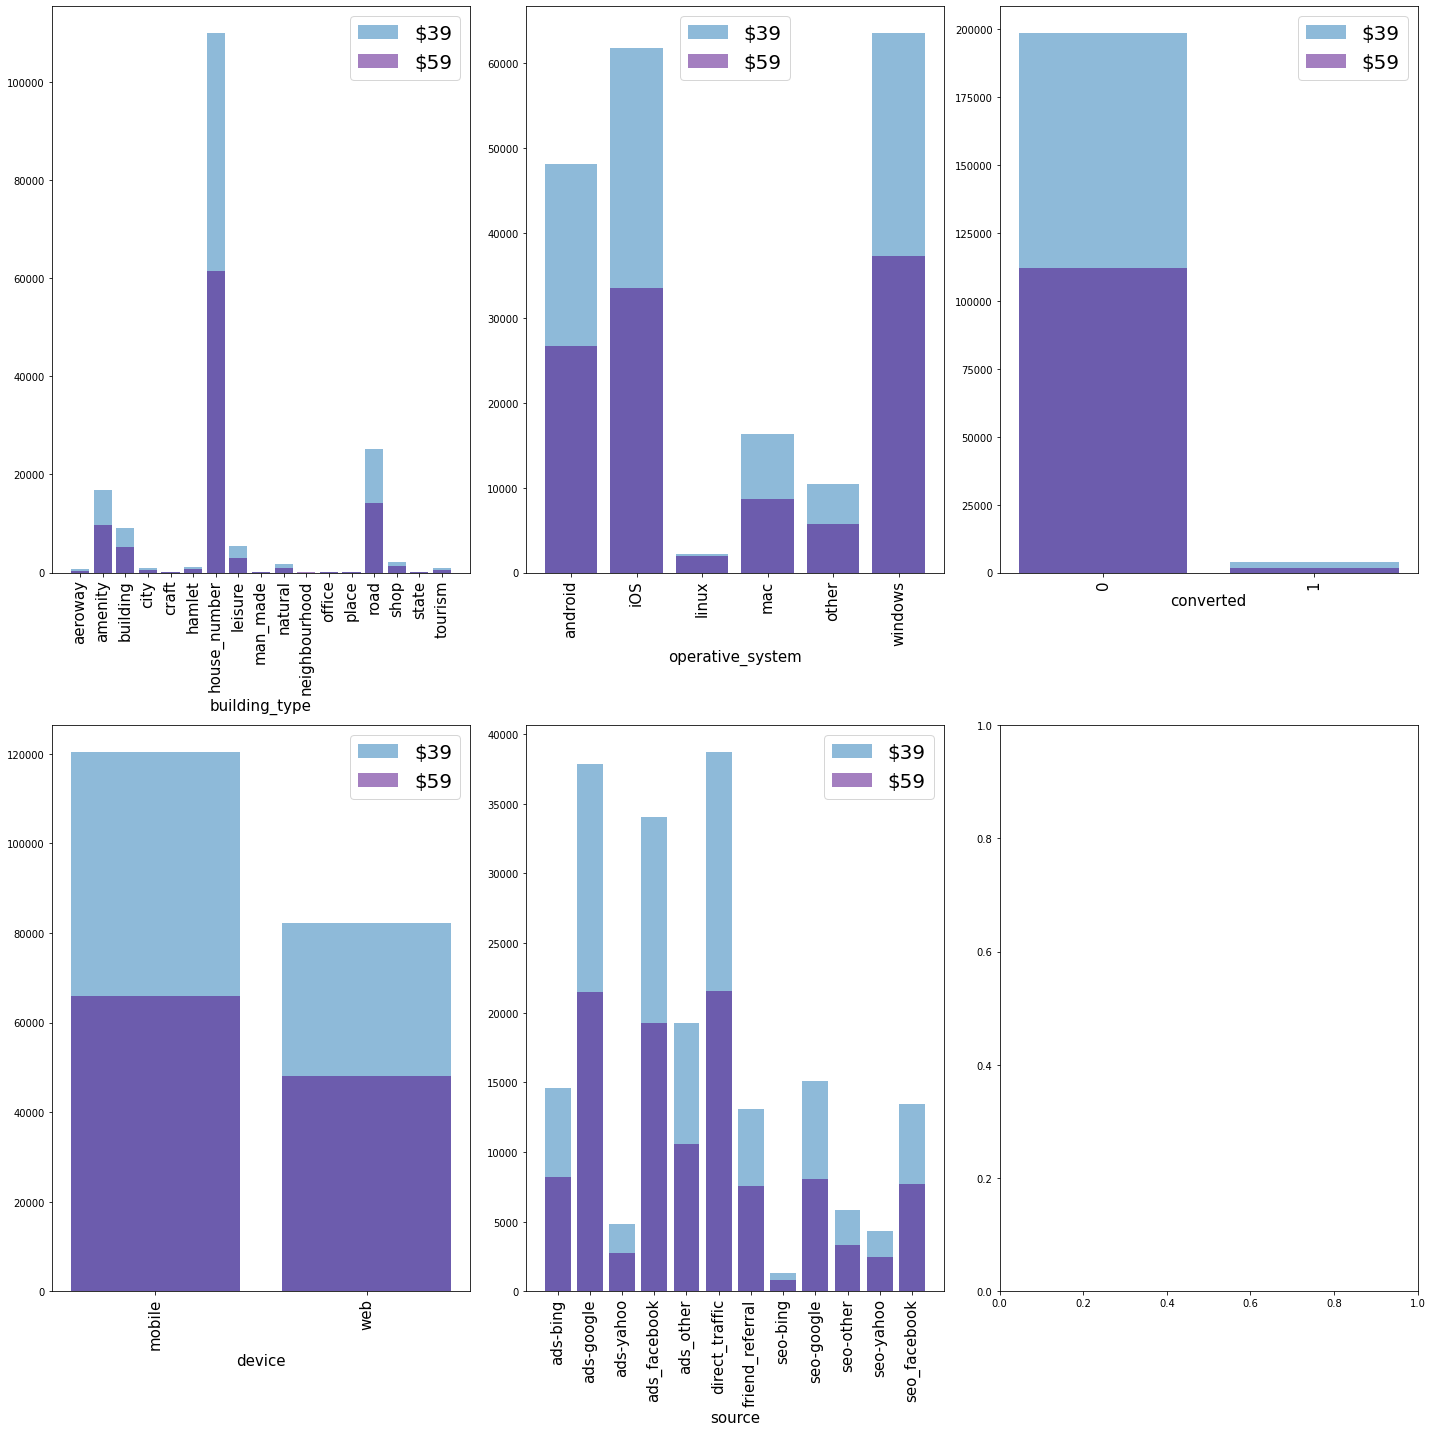

In [353]:
dist_by_price(dft)

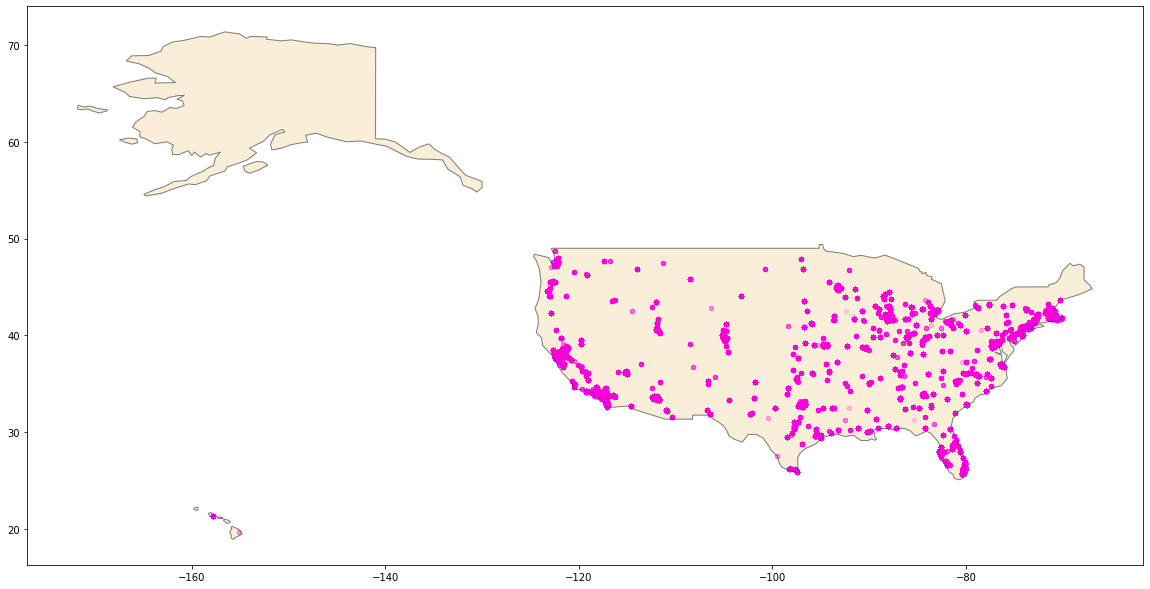

In [354]:
plot_map(dft.dropna())

# AB Testing

#### Conversion rate calculations

In [296]:
num_seeing_39 = dft[dft.price == '39'].price.shape[0]
num_seeing_59 = dft[dft.price == '59'].price.shape[0]
total_seen = dft.shape[0]

num_converted_39 = dft[(dft.price == '39') & (dft.converted == '1')].price.shape[0] 
num_converted_59 = dft[(dft.price == '59') & (dft.converted == '1')].price.shape[0]
total_converted = dft[dft.converted == '1'].price.shape[0]
conversion_rate = total_converted/dft.shape[0] * 100
    
overall_conversion_rate_39 = num_converted_39 / total_converted * 100 
overall_conversion_rate_59 = num_converted_59 / total_converted * 100

group_conversion_rate_39 = num_converted_39 / num_seeing_39 * 100 
group_conversion_rate_59 = num_converted_59 / num_seeing_59 * 100
        
freq_seeing_39 = num_seeing_39 / dft.price.shape[0] * 100
freq_seeing_59 = num_seeing_59 / dft.price.shape[0] * 100
    
profit_per_visit_39 = 39 * (num_converted_39/num_seeing_39)
profit_per_visit_59 = 59 * (num_converted_59/num_seeing_59)
    

In [248]:
display(HTML("""<hr><font color = 'blue'><h3>Findings: Based on overall data, the price 
            increase is a good strategy.</h3><br><font size = 3>
            <li> The majority of purchases were from home addresses using mobile OS or Windows. 
            <li> Far fewer visitors go on to buy the product.
            <li> Direct traffic and ads were the most frequent means of traffic, followed by searches.
            <li> The new price is driving a smaller number of sales, causing a decrease in revenue."""))
display(HTML("<ul><font color = 'blue'> <font size = 3>" + str(round(percent_0,2)) + 
             """<font color = 'blue'> <font size = 3>% of vistors saw the low price."""))
display(HTML("<ul><font color = 'blue'> <font size = 3>" + str(round(100-percent_0,2)) + 
             """<font color = 'blue'> <font size = 3>% of vistors saw the high price."""))
display(HTML("<ul><font color = 'blue'> <font size = 3>" + str(round(overall_conversion_rate_39,2)) + 
             """<font color = 'blue'> <font size = 3>% of conversions were at the low price."""))
display(HTML("<ul><font color = 'blue'> <font size = 3>" + str(round(overall_conversion_rate_59,2)) + 
             """<font color = 'blue'> <font size = 3>% of conversion were at the high price."""))
display(HTML("<ul><font color = 'blue'> <font size = 3>" + str(round(conversion_rate,2)) + 
             """<font color = 'blue'> <font size = 3>% overall conversion rate."""))
display(HTML("<ul><font color = 'blue'> <font size = 3>" + str(round(group_conversion_rate_39,2)) + 
             """<font color = 'blue'> <font size = 3>% conversion rate at the low price."""))
display(HTML("<ul><font color = 'blue'> <font size = 3>" + str(round(group_conversion_rate_59,2)) + 
             """<font color = 'blue'> <font size = 3>% conversion rate at the high price."""))
display(HTML("<ul><font color = 'blue'> <font size = 3>$" + str(round(profit_per_visit_39,2)) + 
             """<font color = 'blue'> <font size = 3>profit per visit at the low price."""))
display(HTML("<ul><font color = 'blue'> <font size = 3>$" + str(round(profit_per_visit_59,2)) + 
             """<font color = 'blue'> <font size = 3>profit per visit at the high price."""))
display(HTML("""<font size = 3><font color = blue><strong> The challenge discription said that 
             33% of visitors saw the new price and %66 saw the old price. After correcting for mismatched
             price/test values, the actual ratio was 64/36%. With this correction, the new price nets 14% 
             more revenue per visitor than the old price per visitor."""))

# Hypothesis testing to see whether the new price is a significant change

### Power Analysis

In [467]:
import statsmodels.api as sm
import statsmodels.stats.power as smso
baseline_rate = num_converted_39/num_seeing_39
practical_significance = 0.01 
confidence_level = 0.05 
sensitivity = 0.85 

effect_size = sm.stats.proportion_effectsize(baseline_conversion_rate, 
              baseline_conversion_rate + practical_significance)
sample_size = smso.NormalIndPower().solve_power(effect_size = effect_size, 
             power = sensitivity, alpha = confidence_level, ratio=1/3)
display(HTML("<hr><font size = 3><font color = 'blue'> Minimum sample size per group: " + 
             str(round(sample_size, 3)) + ' visitors <hr>'))

### Z test 
- I'm choosing the proportions Z-test over t-test because I have a large sample size (over 30 visitors)
- Setting significance threshold to 0.01
- Null hypothesis is that the new price has no effect on conversion rate

#### Calculate the pooled conversion rate, standard error, and margin of error as the basis for comparison

In [332]:
import math
import scipy.stats as sp

prob_pooled = total_converted / total_seen
se_pooled = math.sqrt(prob_pooled * (1 - prob_pooled) * (1 / num_seeing_39 * 39 + 1 / num_seeing_59 * 59))

z_score = sp.norm.ppf(1 - confidence_level / 2)
margin_of_error = se_pooled * z_score
dhat = (num_converted_59 / num_seeing_59 * 59) - (num_converted_39 / num_seeing_39 * 39)

lower_bound = dhat - margin_of_error
upper_bound = dhat + margin_of_error

# One-tailed test
if practical_significance > upper_bound:
    display(HTML("<hr><h3><font color = 'blue'> Finding: Reject null hypothesis"))
else: 
    display(HTML("<hr><h3><font color = 'blue'> Finding: Do not reject the null hypothesis"))

display(HTML("<font size = 3><font color = 'blue'> The difference in revenue between the new and old price is " 
             + str(round(dhat * 100, 2))+ "%"))
display(HTML("<font size = 3><font color = 'blue'> The lower bound of the confidence interval is " 
             + str(round(lower_bound * 100, 2))+ "%"))
display(HTML("<font size = 3><font color = 'blue'> The upper bound of the confidence interval is " 
             + str(round(upper_bound * 100, 2)) + "%<hr>"))


## When should the test have stopped?
- The power analysis indicated a minimum sample size of 8632 visitors per group for a significance level of 0.01.

In [420]:
dft['timestamp_utc'] =  pd.to_datetime(dft.timetamp_utc, format = "%Y-%m-%d", errors = 'ignore').dt.day
dftg = dft.groupby(['timestamp_utc','price']).count().reset_index()
dftg.head()

,timestamp_utc,price,building_type,converted,country,device,operative_system,postcode,source,test,time_zone,timestamp,timetamp_utc,user_id,city,state,lat,long,nearest_city
0,1.0,39,4585,4585,4585,4585,4585,4512,4585,4585,4585,4585,4585,4585,4585,4585,4585,4585,4585
1,1.0,59,2459,2459,2459,2459,2459,2430,2459,2459,2459,2459,2459,2459,2459,2459,2459,2459,2459
2,2.0,39,5345,5345,5345,5345,5345,5303,5345,5345,5345,5345,5345,5345,5345,5345,5345,5345,5345
3,2.0,59,2909,2909,2909,2909,2909,2876,2909,2909,2909,2909,2909,2909,2909,2909,2909,2909,2909
4,3.0,39,6605,6605,6605,6605,6605,6533,6605,6605,6605,6605,6605,6605,6605,6605,6605,6605,6605


#### Plot the visitors as a time series (UTC)

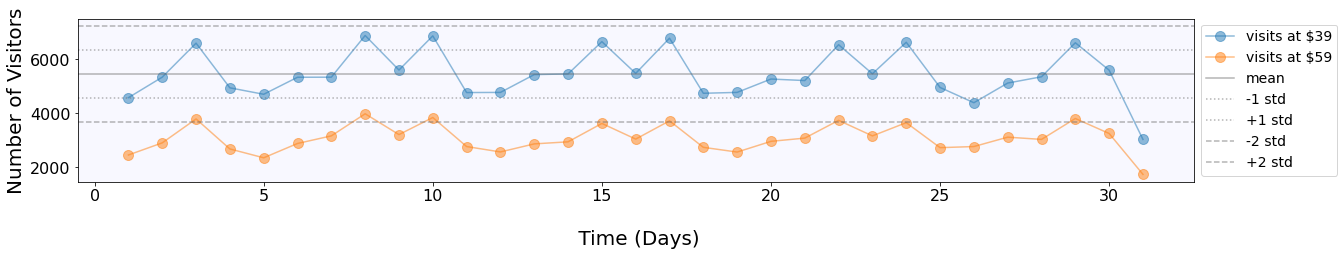

In [423]:
#dftg = subtract_baseline(dftg, 'building_type')
fig7, ax = plt.subplots(1,1, figsize = (20,3))
ax.plot(dftg[dftg.price == '39'].timestamp_utc, dftg[dftg.price == '39'].building_type, marker = 'o', ms = 10,
        alpha = .5, label = 'visits at $39')
ax.plot(dftg[dftg.price == '59'].timestamp_utc, dftg[dftg.price == '59'].building_type, marker = 'o', ms = 10,
        alpha = .5, label = 'visits at $59')
avg = dftg[dftg.price == '39'].building_type.mean()
sd = dftg[dftg.price == '39'].building_type.std()
ax.axhline(avg, color = 'dimgray', ls = '-', alpha = 0.5, label = 'mean')
ax.axhline(avg - sd, color = 'dimgray', ls = ':', alpha = 0.5, label = '-1 std')
ax.axhline(avg + sd, color = 'dimgray', ls = ':', alpha = 0.5, label = '+1 std')
ax.axhline(avg - sd*2, color = 'dimgray', ls = 'dashed', alpha = 0.5, label = '-2 std')
ax.axhline(avg + sd*2, color = 'dimgray', ls = 'dashed', alpha = 0.5, label = '+2 std')
handles, labels = ax.get_legend_handles_labels()
ax.tick_params(labelsize = 16)
ax.set_xlabel('\n Time (Days)', fontsize = 20)
ax.set_ylabel('Number of Visitors', fontsize = 20)
ax.legend(handles,labels, loc='center left', fontsize = 14, bbox_to_anchor=(1, 0.5))
ax.set_facecolor ('ghostwhite')

#### Plot the cumulative sum of visitors over days

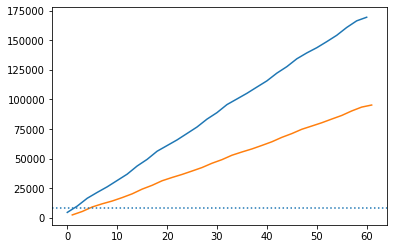

In [472]:
cumulative_39 = dftg[dftg.price == '39'].building_type.cumsum()
cumulative_59 = dftg[dftg.price == '59'].building_type.cumsum()
fig, ax = plt.subplots()
ax.plot(cumulative_39.index.values, cumulative_39)
ax.plot(cumulative_59.index.values, cumulative_59)
ax.axhline(sample_size, ls = ':')

#### Definition for finding the first stopping point

In [469]:
def get_min_days(c, min_visitors):
    for i,v in enumerate(c):
        if v < min_visitors:
            pass
        else:
            stop = c.index.values[i+2] # next day and account for 0 start
            return stop

#### Calculate minimum stopping points for each price group

In [470]:
min_39 = get_min_days(round(cumulative_39), int(sample_size))
min_59 = get_min_days(round(cumulative_59), int(sample_size))
stop_day = max(min_39,min_39)
display(HTML("<hr><h3><font color = 'blue'>Finding: The minimum necessary testing time is " +
             str(stop_day) + ' days.<hr>'))

# What else can the company do to increase revenue?
- The overall conversion rate was under 2%, which is pretty bad. 
- The demographics of the users give hints to where the company can make improvements.

## Strategy involving sources of traffic

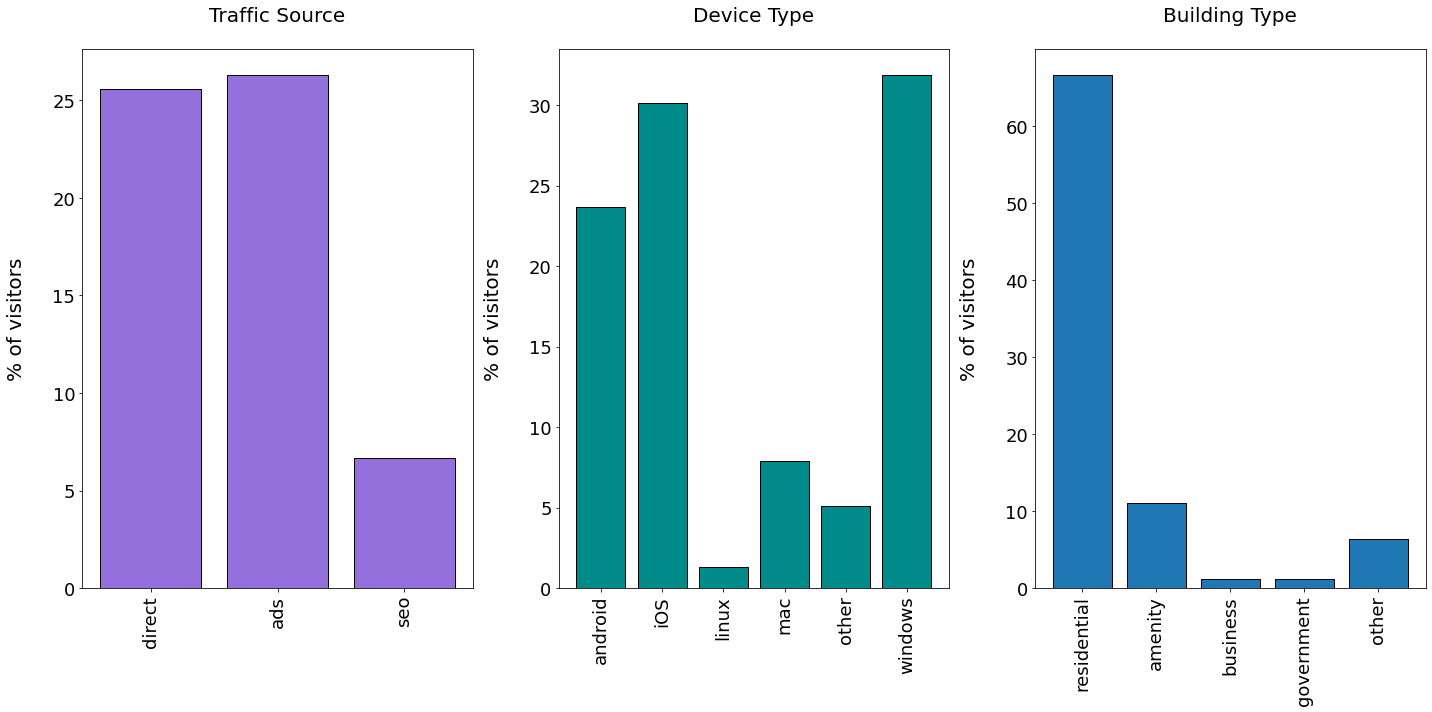

In [388]:
fig, ax = plt.subplots(1,3, figsize = (20, 10))

# Bar chart for traffic source
direct = (dft[dft.source == 'direct_traffic'].shape[0] + \
          dft[dft.source == 'friend_referral'].shape[0])/dft.shape[0]*100
ads = (dft[dft.source == 'ads_bing'].shape[0] + \
          dft[dft.source == 'ads_google'].shape[0] + \
          dft[dft.source == 'ads_yahoo'].shape[0] + \
          dft[dft.source == 'ads_facebook'].shape[0] + \
          dft[dft.source == 'ads_other'].shape[0])/dft.shape[0] * 100
seo = (dft[dft.source == 'seo_bing'].shape[0] + \
          dft[dft.source == 'seo_google'].shape[0] + \
          dft[dft.source == 'seo_yahoo'].shape[0] + \
          dft[dft.source == 'seo_facebook'].shape[0] + \
          dft[dft.source == 'seo_other'].shape[0])/dft.shape[0] * 100
ax[0].bar(['direct', 'ads', 'seo'], 
          height = [direct, ads, seo], color = 'mediumpurple', edgecolor = 'k')
ax[0].tick_params(axis = 'x',labelsize = 18, rotation = 90)
ax[0].tick_params(axis = 'y', labelsize = 18)
ax[0].set_ylabel('% of visitors\n', fontsize = 20)
ax[0].set_title('Traffic Source\n', fontsize = 20)

# Bar chart for device
android = dft[dft.operative_system == 'android'].shape[0]/dft.shape[0] * 100
ios = dft[dft.operative_system == 'iOS'].shape[0] /dft.shape[0] * 100
linux = dft[dft.operative_system == 'linux'].shape[0]/dft.shape[0] * 100
mac = dft[dft.operative_system == 'mac'].shape[0]/dft.shape[0] * 100
other = dft[dft.operative_system == 'other'].shape[0]/dft.shape[0] * 100
windows = dft[dft.operative_system == 'windows'].shape[0]/dft.shape[0] * 100
ax[1].bar(['android', 'iOS', 'linux', 'mac', 'other', 'windows'], 
          height = [android, ios, linux, mac, other, windows], color = 'darkcyan', edgecolor = 'k')
ax[1].tick_params(axis = 'x',labelsize = 18, rotation = 90)
ax[1].tick_params(axis = 'y', labelsize = 18)
ax[1].set_ylabel('% of visitors\n', fontsize = 20)
ax[1].set_title('Device Type\n', fontsize = 20)

# Bar chart for building type
residential = (dft[dft.building_type == 'house_number'].shape[0] + \
              dft[dft.building_type == 'road'].shape[0] + \
              dft[dft.building_type == 'neighborhood'].shape[0])/dft.shape[0] * 100
amenity = (dft[dft.building_type == 'amenity'].shape[0] + \
              dft[dft.building_type == 'craft'].shape[0] + \
              dft[dft.building_type == 'leisure' ].shape[0])/dft.shape[0] * 100
business = (dft[dft.building_type == 'office'].shape[0] + \
              dft[dft.building_type == 'shop'].shape[0])/dft.shape[0] * 100
government = (dft[dft.building_type == 'city'].shape[0] + \
              dft[dft.building_type == 'hamlet'].shape[0] + \
              dft[dft.building_type == 'state'].shape[0])/dft.shape[0] * 100
other = (dft[dft.building_type == 'aeroway'].shape[0] + \
              dft[dft.building_type == 'building'].shape[0] + \
              dft[dft.building_type == 'man-made'].shape[0] + \
              dft[dft.building_type == 'natural'].shape[0] + \
              dft[dft.building_type == 'place'].shape[0] + \
              dft[dft.building_type == 'tourism'].shape[0])/dft.shape[0] * 100
ax[2].bar(['residential', 'amenity', 'business', 'government', 'other'], 
          height = [residential, amenity, business, government, other], edgecolor = 'k')
ax[2].tick_params(axis = 'x',labelsize = 18, rotation = 90)
ax[2].tick_params(axis = 'y', labelsize = 18)
ax[2].set_ylabel('% of visitors\n', fontsize = 20)
ax[2].set_title('Building Type\n', fontsize = 20)

plt.tight_layout()

In [391]:
display(HTML("""<hr><h3><font color = 'blue'>Finding: Search engine optimization is a cost 
             effective means of increasing traffic 
             to the website.</h3><br> <font size = 3> When pooled, the majority of 
             traffic comes from ad sources and least from searches.<br>Ads are costly, but 
             searches are not."""))
display(HTML("""<h3><font color = 'blue'>Finding: There may be a barrier for MacOs users to 
             access the website or use the software.</h3><br> <font size = 3> Mobile and Windows 
             are the most frequently used devices to access the website.<br>This could be of some 
             user-interface or page-loading snaffu on MacOs (and Linux)
             devices, which could be addressed with the UX/UI team.<br> It could also
             be a reflection of the supported platforms of the software, so if the next release is cross-platform
             to support MacOs, there is an untapped market waiting."""))
display(HTML("""<h3><font color = 'blue'>Finding: There is little purchasing of the software 
            by offices and businesses.</h3><br> <font size = 3>If there is a potential user for the software 
            in commerce or government, those are additional untapped markets. <hr>"""))

# Summary

There is a small (14%) increase in the revenue per visitor with the new price of \$59, but was not significant at p <0.05. The conversion rate was very low in both groups and only 1.83\% overall. The majority of purchases were from home addresses using mobile OS or Windows who found their way to the website directly or via ads. Power analysis using the old price as a control specified a minimum of 8632 visitors per group for a significance level of p < 0.01, so the test could have stopped after day 6.  

I recommend leaving the price at \$39 and focus on increasing conversion rate. Invest in search engine optimization to boost traffic to the site. Once the search engine optimization becomes effective, reduce spending on ads to increase your revenue per visitor. Look further into the device types since MacOS users are less likely to visit the page. If it is a UI/UX issue, have the web design team improve it as cross-platform. If the software the company is selling is not MacOS compatible, this is an untapped market for future releases. Most visitors to the website were from residential buildings, leaving businesses and government as untapped markets. If the software is relevant to business and government, future promotions, bulk discounts, and other marketing strategies should include these to increase revenue.